In [10]:
import pandas as pd 
import numpy as np
from forex_python.converter import CurrencyRates
import re
import matplotlib.pyplot as plt
#import scipy
import seaborn as sns
from datetime import datetime, timedelta
import time
import os


import warnings
warnings.filterwarnings('ignore')



Expedia cleaning


In [11]:
Expedia_hotels = pd.read_csv(r"C:\Users\royzo\DS-project\Notebooks\expedia\Expedia_hotels.csv")

In [12]:
df = Expedia_hotels.copy()

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54000 entries, 0 to 53999
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Snapshot                54000 non-null  object 
 1   Index                   54000 non-null  int64  
 2   Hotel Name              53940 non-null  object 
 3   TTT                     53940 non-null  float64
 4   LOS                     53940 non-null  float64
 5   Grade                   53139 non-null  float64
 6   Num of Reviews          53139 non-null  object 
 7   Curr Price              53940 non-null  object 
 8   Original Price          23900 non-null  object 
 9   Percentage of discount  53940 non-null  float64
 10  Distance from center    53940 non-null  float64
 11  Type of room            53940 non-null  float64
 12  Location grade          53940 non-null  float64
 13  Is refundable           53940 non-null  object 
 14  Late payment            53940 non-null

In [14]:
df['Snapshot'] = df['Snapshot'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f').date())
df = df.loc[df['Index'] < 100]
df['Index'] = df['Index'] + 1
df['TTT'] = df['TTT'].astype('int64')
df['LOS'] = df['LOS'].astype('int64')


ValueError: time data '53:54.1' does not match format '%Y-%m-%d %H:%M:%S.%f'

In [15]:
df['Num of Reviews'] = df['Num of Reviews'].apply(lambda x: int(re.sub("[^0-9]", "", x)) if not pd.isnull(x) else x)

In [16]:
df['Num of Reviews']

0        1296.0
1        1002.0
2         305.0
3        3123.0
4        1465.0
          ...  
53995    1000.0
53996    1000.0
53997    1001.0
53998     142.0
53999    1004.0
Name: Num of Reviews, Length: 54000, dtype: float64

In [17]:
df['Grade'].describe()

count    53139.000000
mean         8.412281
std          0.648780
min          5.600000
25%          8.000000
50%          8.600000
75%          8.800000
max         10.000000
Name: Grade, dtype: float64

In [18]:
df.loc[pd.isnull(df['Grade'])]['Hotel Name'].value_counts()

The FIDI Hotel                           233
Latisha luxury place                     173
The Flat NYC                             126
Moxy Brooklyn Willamsburg                115
The Ritz-Carlton New York, NoMad         108
Latisha house                             28
Lovely 2 Bedroom In Brooklyn Sleeps 5     16
Untitled at 3 Freeman Alley                2
Name: Hotel Name, dtype: int64

In [19]:
df.loc[pd.isnull(df['Num of Reviews'])]['Hotel Name'].value_counts()

The FIDI Hotel                           233
Latisha luxury place                     173
The Flat NYC                             126
Moxy Brooklyn Willamsburg                115
The Ritz-Carlton New York, NoMad         108
Latisha house                             28
Lovely 2 Bedroom In Brooklyn Sleeps 5     16
Untitled at 3 Freeman Alley                2
Name: Hotel Name, dtype: int64

In [20]:
df['Curr Price'] = df['Curr Price'].apply(lambda x: x.split('€')[1])

AttributeError: 'float' object has no attribute 'split'

In [ ]:
df['Original Price'] = df['Original Price'].apply(lambda x: x.split('€')[1] if not pd.isnull(x) else x)

In [ ]:
df['Original Price']

In [21]:
df['Original Price'] = df.apply(lambda x: x['Curr Price']  if pd.isnull(x['Original Price']) else x['Original Price'], axis = 1)
df['Original Price']

0          The price was €360
1           The price is €217
2          The price was €493
3           The price is €328
4           The price is €428
                 ...         
53995    The price was €1,935
53996    The price was €3,543
53997    The price was €2,550
53998     The price is €1,606
53999    The price was €1,698
Name: Original Price, Length: 54000, dtype: object

In [22]:
df['Original Price'] = df['Original Price'].apply(lambda x: int(x.replace(',','')))
df['Curr Price'] = df['Curr Price'].apply(lambda x: int(x.replace(',','')))

ValueError: invalid literal for int() with base 10: 'The price was €360'

In [23]:
df['Original Price']  

0          The price was €360
1           The price is €217
2          The price was €493
3           The price is €328
4           The price is €428
                 ...         
53995    The price was €1,935
53996    The price was €3,543
53997    The price was €2,550
53998     The price is €1,606
53999    The price was €1,698
Name: Original Price, Length: 54000, dtype: object

In [24]:
c = CurrencyRates()
x = df['Snapshot'].unique()
curr_dict = {}
for date in x:
    curr_dict[date] = c.get_rate('EUR','USD', date) 

AttributeError: 'str' object has no attribute 'strftime'

In [25]:
curr_dict[df['Snapshot'].iloc[0]]

KeyError: '53:54.1'

In [26]:
df['Original Price']

0          The price was €360
1           The price is €217
2          The price was €493
3           The price is €328
4           The price is €428
                 ...         
53995    The price was €1,935
53996    The price was €3,543
53997    The price was €2,550
53998     The price is €1,606
53999    The price was €1,698
Name: Original Price, Length: 54000, dtype: object

In [27]:
df['Original Price'] = df.apply(lambda x: (x['Original Price']*curr_dict[x['Snapshot']])/x['LOS']  , axis = 1)
df['Curr Price'] = df.apply(lambda x: (x['Curr Price']*curr_dict[x['Snapshot']])/x['LOS']  , axis = 1)

KeyError: '53:54.1'

In [28]:
df['Original Price'] = df['Original Price'].apply(lambda x: round(x,1))
df['Curr Price'] = df['Curr Price'].apply(lambda x: round(x,1))

TypeError: type str doesn't define __round__ method

In [29]:
df[['Original Price','Curr Price']]









,Original Price,Curr Price
0,The price was €360,The price is €278
1,The price is €217,The price is €217
2,The price was €493,The price is €449
3,The price is €328,The price is €328
4,The price is €428,The price is €428
...,...,...
53995,"The price was €1,935","The price is €1,628"
53996,"The price was €3,543","The price is €2,379"
53997,"The price was €2,550","The price is €2,195"
53998,"The price is €1,606","The price is €1,606"


In [ ]:
df.drop(['Percentage of discount', 'Distance from center', 'Type of room',
       'Location grade'], axis = 1, inplace=True)

In [ ]:
df[['Is refundable','Late payment', 'Option Member']] = df[['Is refundable','Late payment', 'Option Member']].astype('int64')

In [ ]:
df['Extras included'] = df['Extras included'].apply(lambda x: 1 if not pd.isnull(x) else 0)

In [ ]:
df.head(20)

Expedia EDA

booking cleaning

In [30]:
df = pd.read_csv(r"C:\Users\royzo\DS-project\Notebooks\Booking\Booking_hotels.csv")


In [31]:
df.head()


,Snapshot,Index,Hotel Name,TTT,LOS,Grade,Num of Reviews,Curr Price,Original Price,Distance from center,Type of room,Location grade,Extra Data
0,2023-03-06 11:24:01.241227,1,Margaritaville Resort Times Square,0,1,8.8,"1,369 reviews",₪ 752,₪ 752,1.5 km from center,Standard Queen Room,Location 9.4,Standard Queen Room\r\n1 queen bed\r\nOnly 1 r...
1,2023-03-06 11:24:01.241227,2,33 Seaport Hotel New York,0,1,8.6,284 reviews,"₪ 1,050\r\nPrice ₪ 1,050","₪ 1,050\r\nPrice ₪ 1,050",6.9 km from center,Superior Courtyard King,NaN,Superior Courtyard King\r\n1 king bed
2,2023-03-06 11:24:01.241227,3,The Belvedere Hotel,0,1,8.0,"3,644 reviews",₪ 510,₪ 510,0.9 km from center,Standard King Room,Location 9.4,Standard King Room\r\n1 king bed\r\nOnly 2 roo...
3,2023-03-06 11:24:01.241227,4,CIVILIAN Hotel,0,1,8.5,"1,172 reviews",₪ 767,₪ 767,0.9 km from center,Double Room,Location 9.5,Double Room\r\n1 queen bed
4,2023-03-06 11:24:01.241227,5,The Cloud One New York-Downtown,0,1,8.2,518 reviews,₪ 620,₪ 620,7 km from center,Standard King Room,NaN,Standard King Room\r\n1 king bed\r\nFREE cance...


In [34]:
# extracting numeric data and removing useless text from prices, location grade, and review. normalize distance from center to m' instead of km, and inserts -1 instead of NaNs

df = pd.read_csv(r"C:\Users\royzo\DS-project\Notebooks\Booking\Booking_hotels.csv")
df[['del', 'Curr Price']] = df['Curr Price'].str.split(' ', 1, expand = True)
df[['Curr Price','del2']] = df['Curr Price'].str.split(r"\r", 0, expand = True)
df[['del', 'Original Price']] = df['Original Price'].str.split(' ', 1, expand = True)
df[['Original Price','del2']] = df['Original Price'].str.split(r"\r", 0, expand = True)
df[['Num of Reviews', 'del']] = df['Num of Reviews'].str.split(' ', 1, expand = True)

df['Distance from center'] = df['Distance from center'].apply(lambda a: int(float(a.split(' ')[0])*1000) if a.split(' ')[1] == 'km' else int(a.split(' ')[0]))
df[['del', 'Location grade']] = df['Location grade'].str.split(' ', 1, expand = True)
df['Location grade'] = df['Location grade'].apply(lambda a: -1 if pd.isna(a) else a)

df = df.drop(columns=['del', 'del2'])

In [35]:
# from datetime to date

df['Snapshot'] = pd.to_datetime(df['Snapshot']).dt.date
df

,Snapshot,Index,Hotel Name,TTT,LOS,Grade,Num of Reviews,Curr Price,Original Price,Distance from center,Type of room,Location grade,Extra Data
0,2023-03-06,1,Margaritaville Resort Times Square,0,1,8.8,"1,369",752,752,1500,Standard Queen Room,9.4,Standard Queen Room\r\n1 queen bed\r\nOnly 1 r...
1,2023-03-06,2,33 Seaport Hotel New York,0,1,8.6,284,"1,050","1,050",6900,Superior Courtyard King,-1,Superior Courtyard King\r\n1 king bed
2,2023-03-06,3,The Belvedere Hotel,0,1,8.0,"3,644",510,510,900,Standard King Room,9.4,Standard King Room\r\n1 king bed\r\nOnly 2 roo...
3,2023-03-06,4,CIVILIAN Hotel,0,1,8.5,"1,172",767,767,900,Double Room,9.5,Double Room\r\n1 queen bed
4,2023-03-06,5,The Cloud One New York-Downtown,0,1,8.2,518,620,620,7000,Standard King Room,-1,Standard King Room\r\n1 king bed\r\nFREE cance...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2023-03-10,96,Aloft Manhattan Downtown - Financial District,29,5,7.5,"1,106","3,841","3,841",6800,"Guest room, 1 Queen",-1,"Guest room, 1 Queen\r\n1 queen bed\r\nFree can..."
44996,2023-03-10,97,Hampton Inn Manhattan/Downtown- Financial Dist...,29,5,7.6,658,"4,459","4,459",7700,Queen Room,-1,Queen Room\r\n1 queen bed\r\nFREE cancellation...
44997,2023-03-10,98,Leon Hotel LES,29,5,8.1,"1,309","5,398","6,748",5900,Superior Queen Room,-1,Superior Queen Room\r\n1 queen bed\r\nFREE can...
44998,2023-03-10,99,SoHo 54,29,5,6.9,"1,562","3,840","4,266",5300,SoHo King,-1,SoHo King\r\n1 king bed\r\nFREE cancellation •...


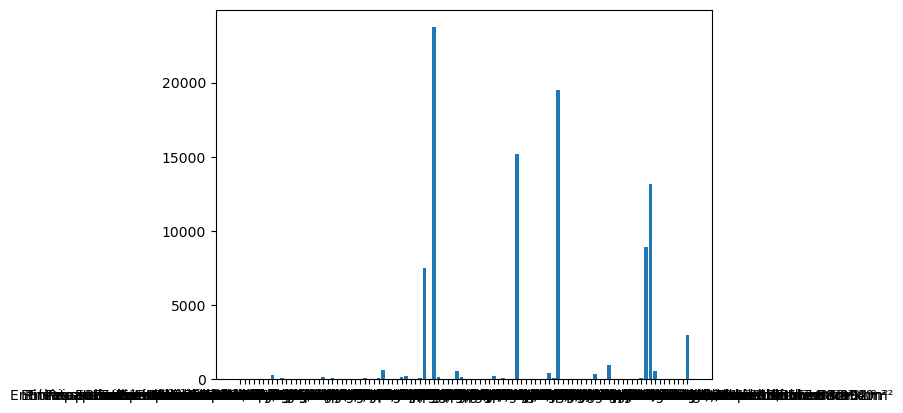

In [36]:
#breaking down 'Extra Data' to categories

op_set = set()
#row = df.head(1)
for index, row in df.iterrows():
    line_list = row['Extra Data'].split('\r\n')[1:-1]
    for item in line_list:
        op_set.add(item)

op_list = []
for index, row in df.iterrows():
    line_list = row['Extra Data'].split('\r\n')[1:-1]
    for item in line_list:
        op_list.append(item)

op_dict = {}
for set_item in op_set:
    count = 0
    for list_item in op_list:
        if list_item == set_item:
            count = count + 1
            
    op_dict[set_item] = count 

names = list(op_dict.keys())
values = list(op_dict.values())

plt.bar(range(len(op_dict)), values, tick_label=names)
plt.show()

In [37]:
# focusing on top categories, ignoring bed count and other generic cats
sorted(op_dict.items(), key=lambda x: x[1], reverse=True)

[('FREE cancellation • No prepayment needed', 23734),
 ('1 king bed', 19514),
 ('You can cancel later, so lock in this great price today!', 15192),
 ('1 queen bed', 13172),
 ('Breakfast included', 8929),
 ('Free cancellation', 7520),
 ('1 full bed', 2975),
 ('2 full beds', 972),
 ('Private suite', 599),
 ('2 beds (1 king, 1 sofa bed)', 560),
 ('1 bunk bed', 558),
 ('2 twin beds', 455),
 ('2 queen beds', 354),
 ('Entire studio • 1 bathroom • 19m²', 317),
 ('Entire studio • 1 bathroom • 25m²', 239),
 ('2 beds (1 sofa bed, 1 queen)', 216),
 ('Entire studio • 1 bathroom • 325m²', 172),
 ('Entire studio • 1 bathroom • 18m²', 166),
 ('Entire studio • 1 bathroom • 20m²', 160),
 ('Private suite • 1 bedroom • 1 living room • 1 bathroom • 28m²', 138),
 ('1 twin bed', 115),
 ('Entire studio • 1 bathroom • 28m²', 96),
 ('Entire studio • 1 bathroom • 29m²', 65),
 ('Beds: 1 double or 2 twins', 64),
 ('Private suite • 1 bedroom • 1 living room • 1 bathroom • 30m²', 63),
 ('4 twin beds', 62),
 ('Entir

In [38]:
# combining cats for free cancelation and comparing counts
cancellation_count = 0
for index, row in df.iterrows():
    line_list = row['Extra Data'].split('\r\n')[1:-1]
    if ('FREE cancellation • No prepayment needed' in line_list) or ('Free cancellation' in line_list):
        cancellation_count = cancellation_count + 1
        
print(cancellation_count)

df['Free Cancellation'] = df['Extra Data'].apply(lambda a: True if 
                                                 ('FREE cancellation • No prepayment needed' in a.split('\r\n')) 
                                                 or ('Free cancellation' in a.split('\r\n')) else False)
df.groupby('Free Cancellation').count()

31254


,Snapshot,Index,Hotel Name,TTT,LOS,Grade,Num of Reviews,Curr Price,Original Price,Distance from center,Type of room,Location grade,Extra Data
Free Cancellation,,,,,,,,,,,,,
False,13746,13746,13746,13746,13746,13746,13746,13746,13746,13746,13746,13746,13746
True,31254,31254,31254,31254,31254,31254,31254,31254,31254,31254,31254,31254,31254


In [39]:
# converting top categories to bool

df['No prepayment needed'] = df['Extra Data'].apply(lambda a: True if 
                                                 ('FREE cancellation • No prepayment needed' in a.split('\r\n')) else False)
df['Breakfast included'] = df['Extra Data'].apply(lambda a: True if 
                                                 ('Breakfast included' in a.split('\r\n')) else False)
df['Cancel Later'] = df['Extra Data'].apply(lambda a: True if 
                                                 ('You can cancel later, so lock in this great price today!' in a.split('\r\n')) else False)
df = df.drop(columns=['Extra Data'])

In [40]:
#converting ILS to USD for comparison to expedia
c = CurrencyRates()
x = df['Snapshot'].unique()
curr_dict = {}
for date in x:
    print()
    curr_dict[date] = c.get_rate('ILS','USD', date)


In [41]:
df['Original Price'] = df['Original Price'].apply(lambda x: int(x.replace(',','')))
df['Curr Price'] = df['Curr Price'].apply(lambda x: int(x.replace(',','')))

In [43]:
df['Original Price'] = df.apply(lambda x: (x['Original Price']*curr_dict[x['Snapshot']])/x['LOS']  , axis = 1)
df['Curr Price'] = df.apply(lambda x: (x['Curr Price']*curr_dict[x['Snapshot']])/x['LOS']  , axis = 1)

In [44]:
df

,Snapshot,Index,Hotel Name,TTT,LOS,Grade,Num of Reviews,Curr Price,Original Price,Distance from center,Type of room,Location grade,Free Cancellation,No prepayment needed,Breakfast included,Cancel Later
0,2023-03-06,1,Margaritaville Resort Times Square,0,1,8.8,"1,369",210.251208,210.251208,1500,Standard Queen Room,9.4,False,False,False,False
1,2023-03-06,2,33 Seaport Hotel New York,0,1,8.6,284,293.568841,293.568841,6900,Superior Courtyard King,-1,False,False,False,False
2,2023-03-06,3,The Belvedere Hotel,0,1,8.0,"3,644",142.590580,142.590580,900,Standard King Room,9.4,False,False,False,False
3,2023-03-06,4,CIVILIAN Hotel,0,1,8.5,"1,172",214.445048,214.445048,900,Double Room,9.5,False,False,False,False
4,2023-03-06,5,The Cloud One New York-Downtown,0,1,8.2,518,173.345411,173.345411,7000,Standard King Room,-1,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2023-03-10,96,Aloft Manhattan Downtown - Financial District,29,5,7.5,"1,106",214.780556,214.780556,6800,"Guest room, 1 Queen",-1,True,False,False,True
44996,2023-03-10,97,Hampton Inn Manhattan/Downtown- Financial Dist...,29,5,7.6,658,249.337802,249.337802,7700,Queen Room,-1,True,True,False,True
44997,2023-03-10,98,Leon Hotel LES,29,5,8.1,"1,309",301.844686,377.333816,5900,Superior Queen Room,-1,True,True,False,True
44998,2023-03-10,99,SoHo 54,29,5,6.9,"1,562",214.724638,238.545652,5300,SoHo King,-1,True,True,False,True


booking EDA

(array([6310., 4784., 6163., 2732., 6349., 4556., 3596., 3834., 4035.,
        2641.]),
 array([  0. ,  84.3, 168.6, 252.9, 337.2, 421.5, 505.8, 590.1, 674.4,
        758.7, 843. ]),
 <BarContainer object of 10 artists>)

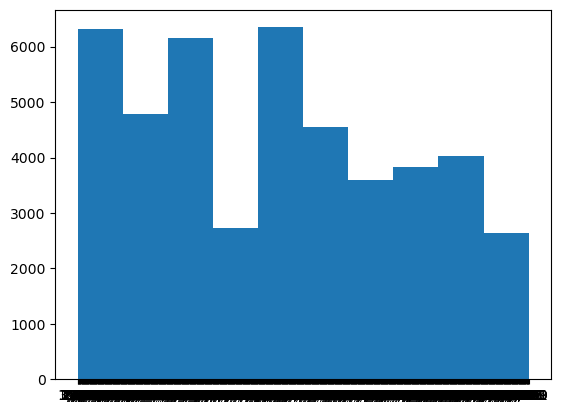

In [45]:
plt.hist(df['Num of Reviews'])

(array([6310., 4784., 6163., 2732., 6349., 4556., 3596., 3834., 4035.,
        2641.]),
 array([  0. ,  84.3, 168.6, 252.9, 337.2, 421.5, 505.8, 590.1, 674.4,
        758.7, 843. ]),
 <BarContainer object of 10 artists>)

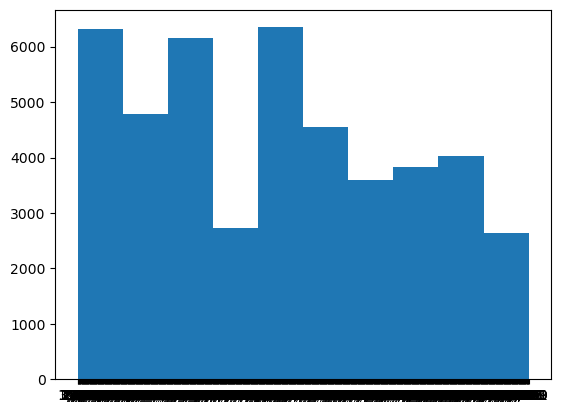

In [46]:
plt.hist(df['Num of Reviews'])

(array([4.2840e+03, 1.9967e+04, 1.4859e+04, 4.5580e+03, 9.7400e+02,
        2.1300e+02, 5.9000e+01, 5.2000e+01, 7.0000e+00, 2.7000e+01]),
 array([  83.87681159,  185.28387681,  286.69094203,  388.09800725,
         489.50507246,  590.91213768,  692.3192029 ,  793.72626812,
         895.13333333,  996.54039855, 1097.94746377]),
 <BarContainer object of 10 artists>)

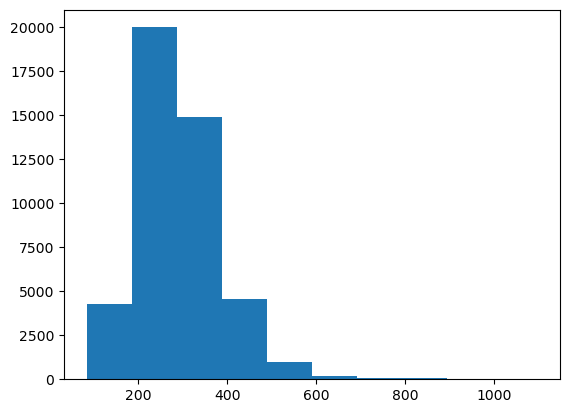

In [47]:
plt.hist(df['Curr Price'])

In [48]:
q1 = df['Curr Price'].quantile(0.25)
q3 = df['Curr Price'].quantile(0.75)
iqr = q3-q1
top_lim = q3 + 1.5*iqr
bottom_lim = q1 - 1.5* iqr
df = df.drop(df[df['Curr Price'] > top_lim].index)
df = df.drop(df[df['Curr Price'] < bottom_lim].index)

{'whiskers': [<matplotlib.lines.Line2D at 0x2b16c7aad30>,
 'caps': [<matplotlib.lines.Line2D at 0x2b16c7c4310>,
 'boxes': [<matplotlib.lines.Line2D at 0x2b16b78b7f0>],
 'medians': [<matplotlib.lines.Line2D at 0x2b16c7c48b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2b16c7c4b80>],
 'means': []}

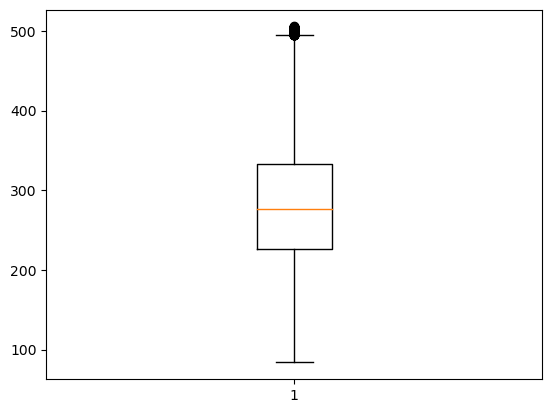

In [49]:
plt.boxplot(df['Curr Price'])

In [50]:
df

,Snapshot,Index,Hotel Name,TTT,LOS,Grade,Num of Reviews,Curr Price,Original Price,Distance from center,Type of room,Location grade,Free Cancellation,No prepayment needed,Breakfast included,Cancel Later
0,2023-03-06,1,Margaritaville Resort Times Square,0,1,8.8,"1,369",210.251208,210.251208,1500,Standard Queen Room,9.4,False,False,False,False
1,2023-03-06,2,33 Seaport Hotel New York,0,1,8.6,284,293.568841,293.568841,6900,Superior Courtyard King,-1,False,False,False,False
2,2023-03-06,3,The Belvedere Hotel,0,1,8.0,"3,644",142.590580,142.590580,900,Standard King Room,9.4,False,False,False,False
3,2023-03-06,4,CIVILIAN Hotel,0,1,8.5,"1,172",214.445048,214.445048,900,Double Room,9.5,False,False,False,False
4,2023-03-06,5,The Cloud One New York-Downtown,0,1,8.2,518,173.345411,173.345411,7000,Standard King Room,-1,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2023-03-10,96,Aloft Manhattan Downtown - Financial District,29,5,7.5,"1,106",214.780556,214.780556,6800,"Guest room, 1 Queen",-1,True,False,False,True
44996,2023-03-10,97,Hampton Inn Manhattan/Downtown- Financial Dist...,29,5,7.6,658,249.337802,249.337802,7700,Queen Room,-1,True,True,False,True
44997,2023-03-10,98,Leon Hotel LES,29,5,8.1,"1,309",301.844686,377.333816,5900,Superior Queen Room,-1,True,True,False,True
44998,2023-03-10,99,SoHo 54,29,5,6.9,"1,562",214.724638,238.545652,5300,SoHo King,-1,True,True,False,True
